<a href="https://colab.research.google.com/github/vikashmaheshwari97/Concept-Drfit-Adaptation/blob/main/Credit_Card_CD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems
This is the code for the paper entitled "**A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems**" accepted in *IEEE Transactions on Industrial Informatics* (IF: 11.648).  <br>
Authors: Li Yang (lyang339@uwo.ca) and Abdallah Shami (Abdallah.Shami@uwo.ca)  <br>
Organization: The Optimized Computing and Communications (OC2) Lab, ECE Department, Western University

L. Yang and A. Shami, "A Multi-Stage Automated Online Network Data Stream Analytics Framework For IIoT Systems," IEEE Transactions on Industrial Informatics, pp. 1-10, 2022.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Load Data and Define Functions

## Import libraries

In [15]:
!pip install river==0.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

#import river, an online learning library
from river import feature_selection
from river import stats
from river import imblearn
from river import preprocessing
from river import evaluate
from river import metrics
from river import tree

In [60]:
import warnings
warnings.filterwarnings('ignore')

## Dataset 1: CICIDS2017
A subset of the network traffic data randomly sampled from the [CICIDS2017 dataset](https://www.unb.ca/cic/datasets/ids-2017.html).  

The Canadian Institute for Cybersecurity Intrusion Detection System 2017 (CICIDS2017) dataset has the most updated network threats. The CICIDS2017 dataset is close to real-world network data since it has a large amount of network traffic data, a variety of network features, various types of attacks, and highly imbalanced classes.

## Read the sampled CICIDS2017 dataset

In [61]:
df = pd.read_csv("/content/drive/MyDrive/card_transdata.csv")

df = df.sample(n=None, frac=0.1, random_state=None, axis=0)
df = df.sort_index()

In [62]:
df

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
7,4.848247,0.320735,1.273050,1.0,0.0,1.0,0.0,0.0
28,3.216045,17.144736,1.788833,1.0,1.0,0.0,1.0,0.0
29,15.694986,175.989182,0.855623,1.0,0.0,0.0,1.0,1.0
46,5.471114,1.024178,0.067181,1.0,0.0,0.0,0.0,0.0
54,151.370437,5.340081,1.171567,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
999940,4.977575,0.068581,0.444834,1.0,1.0,0.0,1.0,0.0
999951,5.636073,0.683975,0.272742,1.0,1.0,0.0,0.0,0.0
999958,1.279881,0.938705,2.563840,0.0,0.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0


In [63]:
# Cheking percent of missing values in columns
df_missing_columns = (round(((df.isnull().sum()/len(df.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
df_missing_columns

,null
distance_from_home,0.0
distance_from_last_transaction,0.0
ratio_to_median_purchase_price,0.0
repeat_retailer,0.0
used_chip,0.0
used_pin_number,0.0
online_order,0.0
fraud,0.0


## Train-test split
10% training set, and 90% test set

In [64]:
X = df.drop(['fraud'],axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Basic Adaptive Learning - Define Functions

In [65]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [66]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set
    
    eddm = EDDM()
    
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1) 

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy
        
        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        if in_drift:
            print(f"Change detected at index {i}")
        
        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [67]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6)) 
    sns.set_style("darkgrid")
    plt.clf() 
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on Credit Card Dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

Change detected at index 2647
Change detected at index 5471
Change detected at index 9250
Change detected at index 13923
Change detected at index 18818
Change detected at index 21841
Change detected at index 27216
Change detected at index 32820
Change detected at index 40364
Change detected at index 44904
Change detected at index 47153
Change detected at index 51198
Change detected at index 54934
Change detected at index 69501
Change detected at index 72501
Change detected at index 77820
Change detected at index 83533
Accuracy: 99.19%
Precision: 96.72%
Recall: 93.81%
F1-score: 95.25%
CPU times: user 1min 32s, sys: 2.91 s, total: 1min 35s
Wall time: 1min 36s


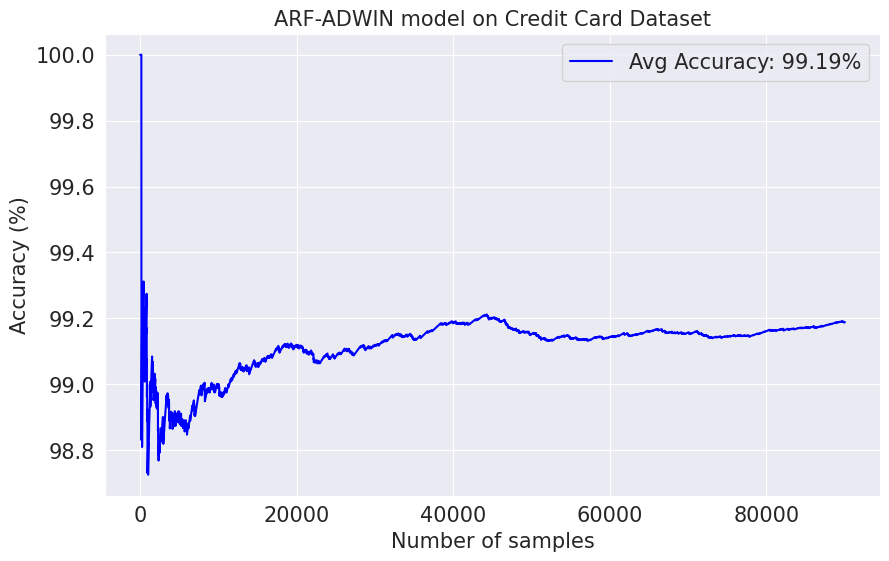

In [68]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector as a baseline model
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 2. Dynamic Data Pre-Processing

The dynamic data pre-processing part focuses on data balancing and data normalization. Examples of using them are given below.   
* Data balancing methods include Dynamic Random Under-Sampling (DRUS) and Dynamic Random Over-Sampling (DROS);  
* Data normalization methods include dynamic min-max and Z-score scalers.  <br>


Change detected at index 2770
Change detected at index 2978
Change detected at index 3390
Change detected at index 3671
Change detected at index 19847
Change detected at index 20272
Change detected at index 20888
Change detected at index 21397
Change detected at index 22272
Change detected at index 22691
Change detected at index 23106
Change detected at index 23533
Change detected at index 24239
Change detected at index 24890
Change detected at index 25501
Change detected at index 25973
Change detected at index 26813
Change detected at index 27510
Change detected at index 28207
Accuracy: 96.48%
Precision: 72.00999999999999%
Recall: 97.26%
F1-score: 82.75%
CPU times: user 33.3 s, sys: 1.13 s, total: 34.5 s
Wall time: 34.2 s


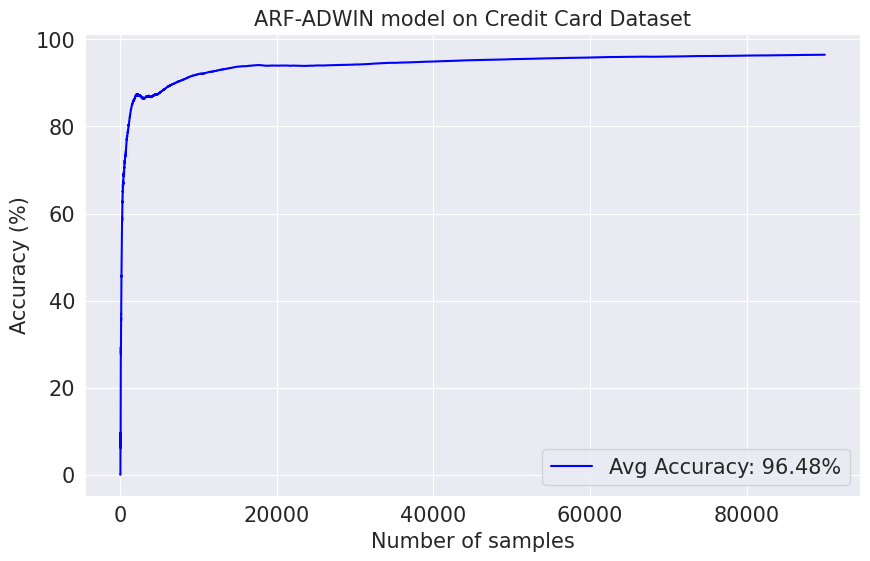

In [70]:
%%time
# Min-max normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 2726
Change detected at index 2869
Change detected at index 2918
Change detected at index 3936
Change detected at index 11718
Change detected at index 13674
Change detected at index 14010
Change detected at index 14229
Change detected at index 14642
Change detected at index 15096
Change detected at index 15411
Change detected at index 15841
Change detected at index 16042
Change detected at index 16432
Change detected at index 16846
Change detected at index 17201
Change detected at index 17761
Change detected at index 18312
Change detected at index 18695
Change detected at index 19134
Change detected at index 21290
Change detected at index 21916
Change detected at index 22759
Change detected at index 23581
Change detected at index 24358
Change detected at index 25246
Change detected at index 25928
Change detected at index 26580
Change detected at index 27268
Change detected at index 28099
Change detected at index 28772
Change detected at index 29919
Change detec

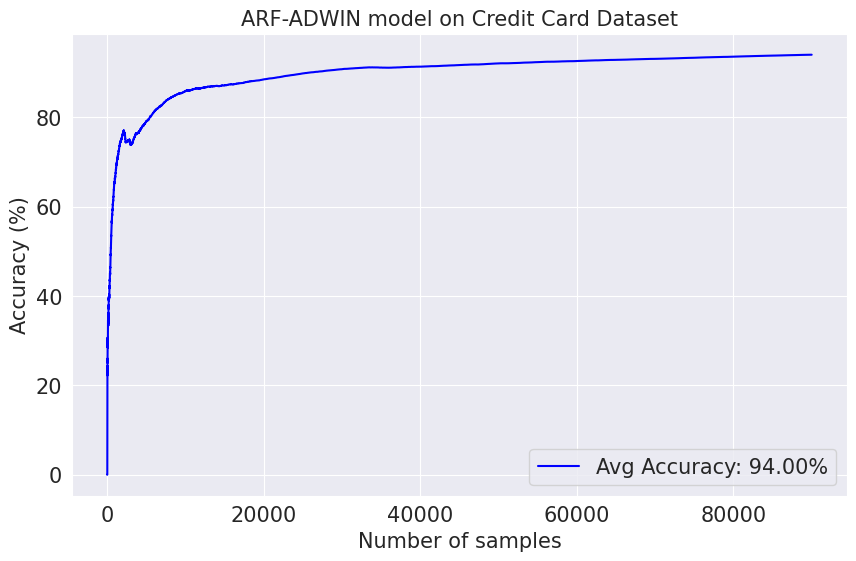

In [71]:
%%time
# Z-score normalization & random under-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomUnderSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 233
Change detected at index 618
Change detected at index 864
Change detected at index 1171
Change detected at index 6760
Change detected at index 7824
Change detected at index 9588
Change detected at index 10352
Change detected at index 11390
Change detected at index 11889
Change detected at index 12435
Change detected at index 12925
Change detected at index 13586
Change detected at index 14719
Change detected at index 15200
Change detected at index 15668
Change detected at index 16468
Change detected at index 16988
Change detected at index 17760
Change detected at index 20738
Change detected at index 22337
Change detected at index 23023
Change detected at index 25076
Change detected at index 28975
Change detected at index 29555
Change detected at index 30187
Change detected at index 30578
Change detected at index 31172
Change detected at index 31568
Change detected at index 32345
Change detected at index 33393
Change detected at index 34133
Change detected at

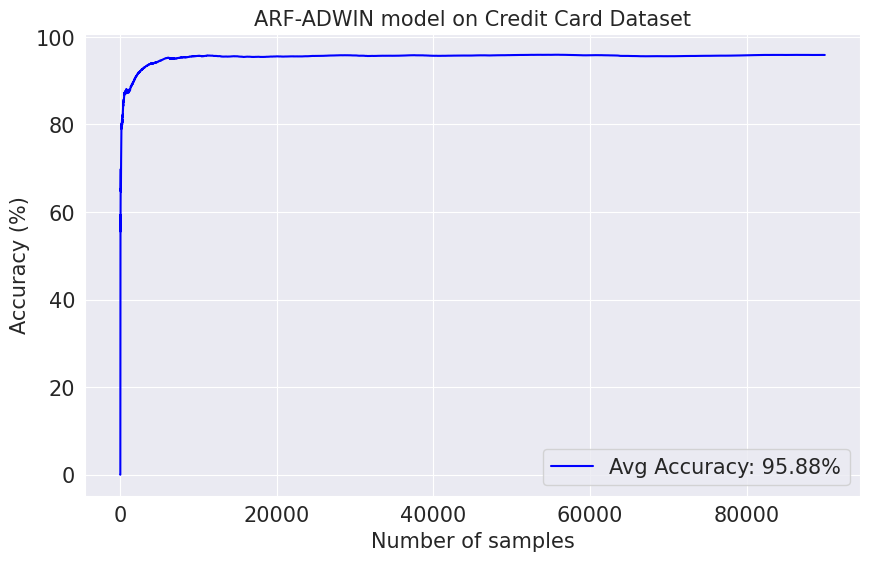

In [72]:
%%time
# Min-max normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.MinMaxScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 18552
Change detected at index 19638
Change detected at index 20171
Change detected at index 20801
Change detected at index 21291
Change detected at index 21973
Change detected at index 22938
Change detected at index 24805
Change detected at index 25199
Change detected at index 25717
Change detected at index 26381
Change detected at index 27188
Change detected at index 28131
Change detected at index 30849
Change detected at index 32047
Change detected at index 32452
Change detected at index 33286
Change detected at index 34337
Change detected at index 34890
Change detected at index 36073
Change detected at index 37305
Change detected at index 39000
Change detected at index 46052
Change detected at index 46691
Change detected at index 47356
Change detected at index 48109
Change detected at index 48772
Change detected at index 50850
Change detected at index 51822
Change detected at index 52763
Change detected at index 53859
Change detected at index 54181
Change d

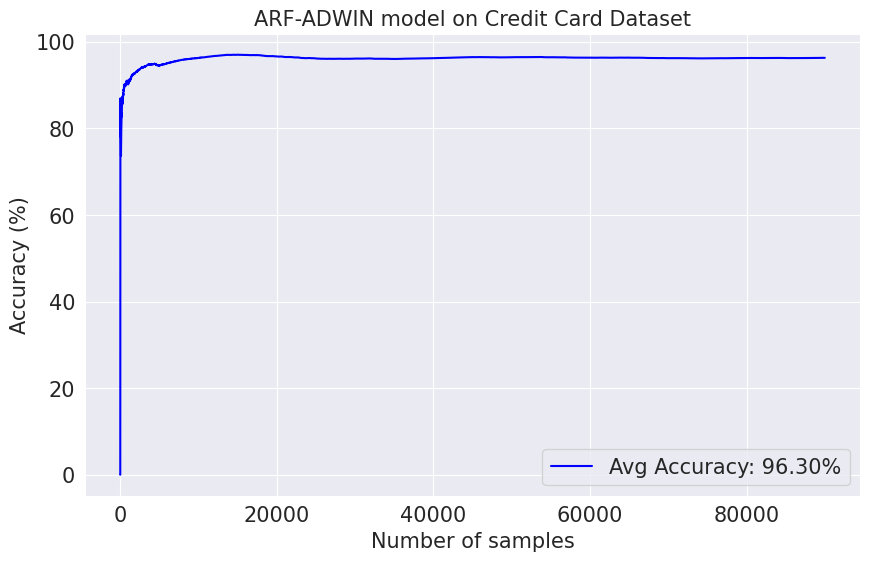

In [73]:
%%time
# Z-score normalization & random over-sampling
name1 = "ARF-ADWIN model"

model1 = imblearn.RandomOverSampler( (
                                    preprocessing.StandardScaler() |
                                    ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN())),
                                    desired_dist={0: 0.4, 1: 0.6}) 
                        # Ensure the ratio of the minority and the majority class samples is more than 2/3. 
                        # This rario can be changed according to specific situations.

t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

# 3. Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) with ADWIN drift detector
* Adaptive Random Forest (ARF) with EDDM drift detector
* Streaming Random Patches (SRP)
* Extremely Fast Decision Tree (EFDT)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Self Adapting Memory (SAM) KNN model (SAM-KNN)
* Online Passive-Aggressive (OPA)
* Leveraging Bagging (LB)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed in the previous work
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed

Change detected at index 3307
Change detected at index 5726
Accuracy: 99.22%
Precision: 97.07000000000001%
Recall: 93.88%
F1-score: 95.45%
CPU times: user 1min 33s, sys: 3.03 s, total: 1min 36s
Wall time: 1min 35s


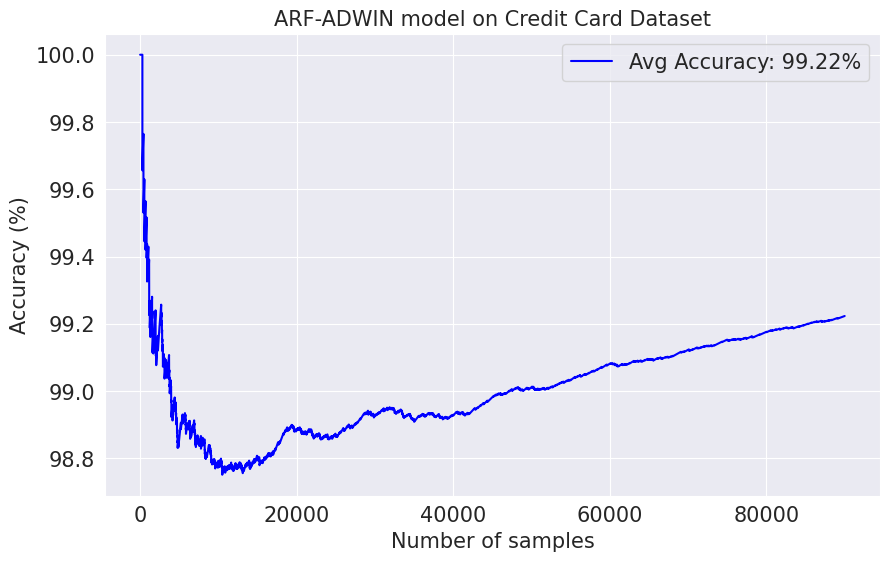

In [75]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN model"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 2495
Change detected at index 6393
Change detected at index 10318
Change detected at index 13241
Change detected at index 17065
Change detected at index 21773
Change detected at index 34826
Accuracy: 99.47%
Precision: 97.47%
Recall: 96.35000000000001%
F1-score: 96.91%
CPU times: user 1min 57s, sys: 2.88 s, total: 2min
Wall time: 2min 5s


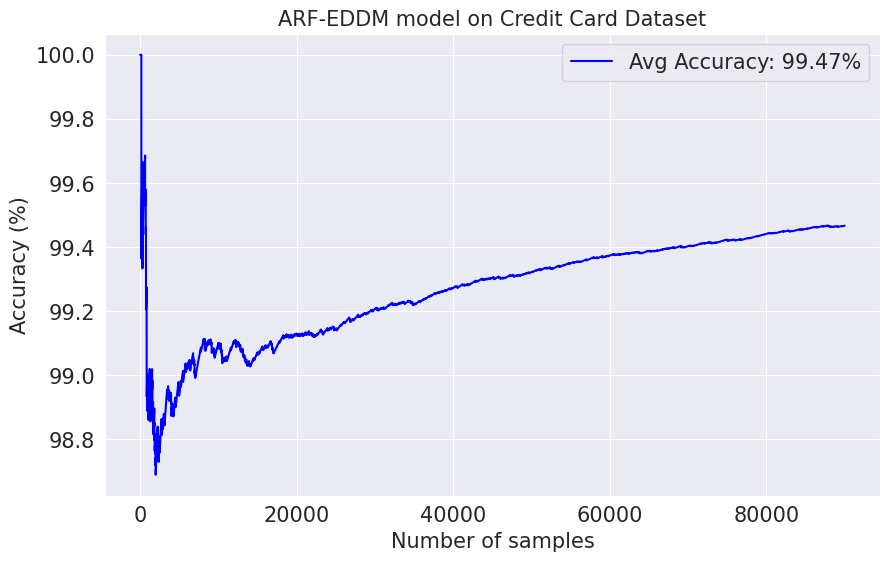

In [79]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM model"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 542
Change detected at index 1005
Change detected at index 1828
Change detected at index 2516
Change detected at index 3065
Change detected at index 3752
Change detected at index 4253
Change detected at index 4827
Change detected at index 5646
Change detected at index 6225
Change detected at index 6973
Change detected at index 11769
Change detected at index 12260
Change detected at index 13650
Change detected at index 14143
Change detected at index 14699
Change detected at index 15353
Change detected at index 15893
Change detected at index 16407
Change detected at index 16972
Change detected at index 17475
Change detected at index 17980
Change detected at index 18443
Change detected at index 18962
Change detected at index 19870
Change detected at index 20980
Change detected at index 21599
Change detected at index 22138
Change detected at index 22804
Change detected at index 23480
Accuracy: 94.47%
Precision: 67.23%
Recall: 70.78%
F1-score: 68.96%
CPU times: user

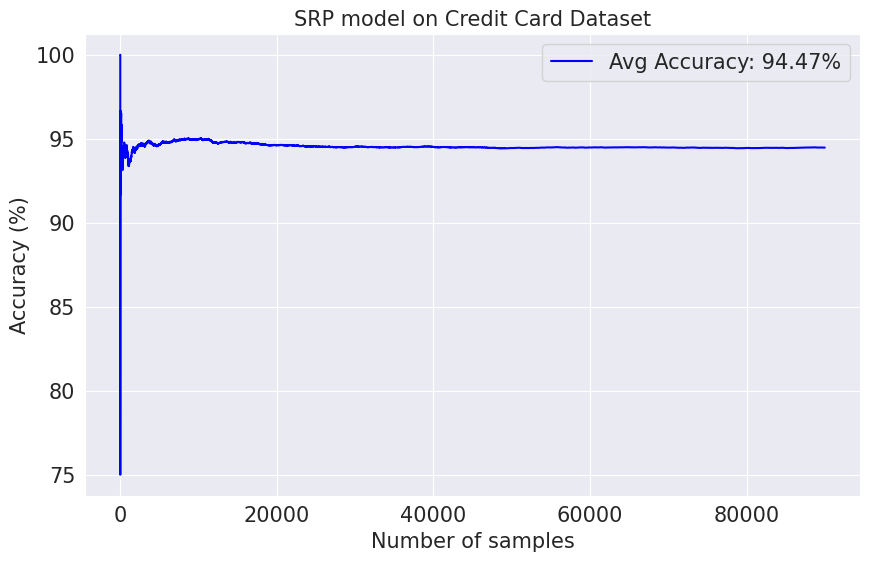

In [82]:
%%time
# Use the Streaming Random Patches (SRP) model
name3 = "SRP model"
model3 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 731
Change detected at index 1688
Change detected at index 2810
Change detected at index 3969
Change detected at index 4896
Change detected at index 6106
Change detected at index 7005
Change detected at index 8117
Change detected at index 23244
Change detected at index 24457
Change detected at index 25558
Change detected at index 26850
Change detected at index 28083
Change detected at index 29283
Change detected at index 30312
Change detected at index 32498
Change detected at index 33762
Change detected at index 35238
Change detected at index 36399
Change detected at index 37760
Change detected at index 38745
Change detected at index 43228
Change detected at index 44225
Change detected at index 78643
Change detected at index 80046
Change detected at index 81223
Change detected at index 82852
Change detected at index 84144
Accuracy: 97.97%
Precision: 89.60000000000001%
Recall: 86.72%
F1-score: 88.13%
CPU times: user 7min 49s, sys: 1.58 s, total: 7min 50s
Wall ti

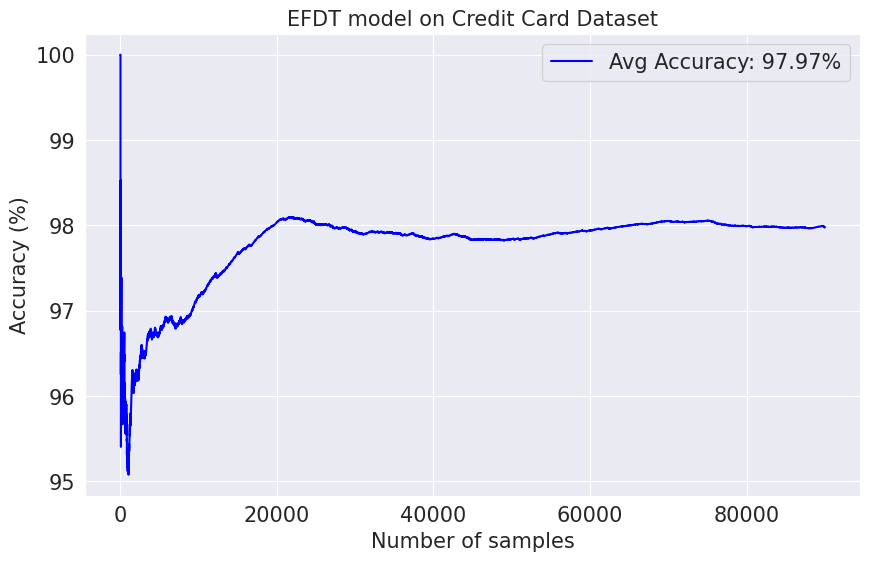

In [84]:
%%time
# Use the Extremely Fast Decision Tree (EFDT) model 
name4 = "EFDT model"
model4 = tree.ExtremelyFastDecisionTreeClassifier() # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 427
Change detected at index 780
Change detected at index 1015
Change detected at index 1363
Change detected at index 1760
Change detected at index 3113
Change detected at index 3602
Change detected at index 3915
Change detected at index 4437
Change detected at index 4776
Change detected at index 5142
Change detected at index 5518
Change detected at index 5945
Change detected at index 6368
Change detected at index 6804
Change detected at index 7177
Change detected at index 10123
Change detected at index 10515
Change detected at index 11437
Change detected at index 11802
Change detected at index 12075
Change detected at index 12484
Change detected at index 12901
Change detected at index 13271
Change detected at index 13686
Change detected at index 14057
Change detected at index 14444
Change detected at index 15158
Change detected at index 15536
Change detected at index 15942
Change detected at index 16365
Change detected at index 16778
Accuracy: 91.4900000000000

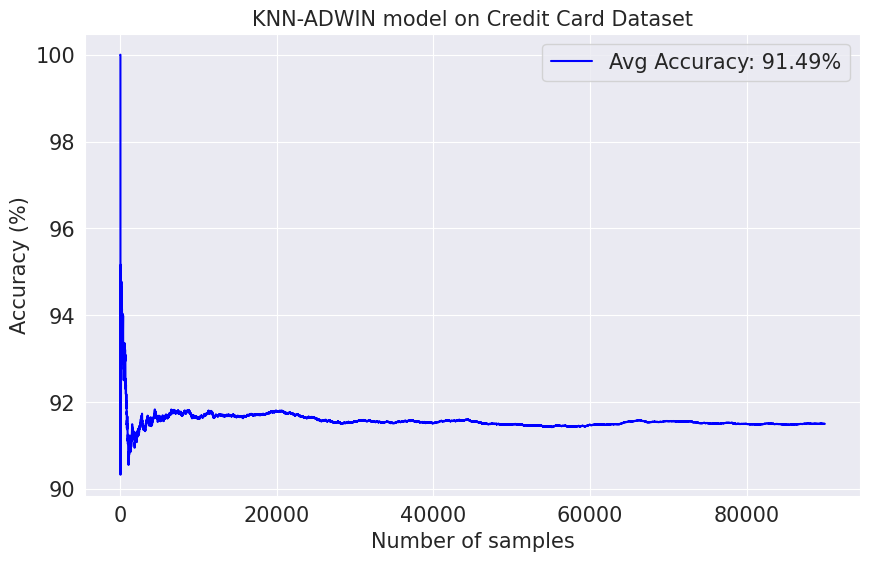

In [86]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN model"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 405
Change detected at index 689
Change detected at index 941
Change detected at index 1310
Change detected at index 1688
Accuracy: 91.3%
Precision: 49.24%
Recall: 11.129999999999999%
F1-score: 18.16%
CPU times: user 3min 17s, sys: 1.52 s, total: 3min 19s
Wall time: 2min 5s


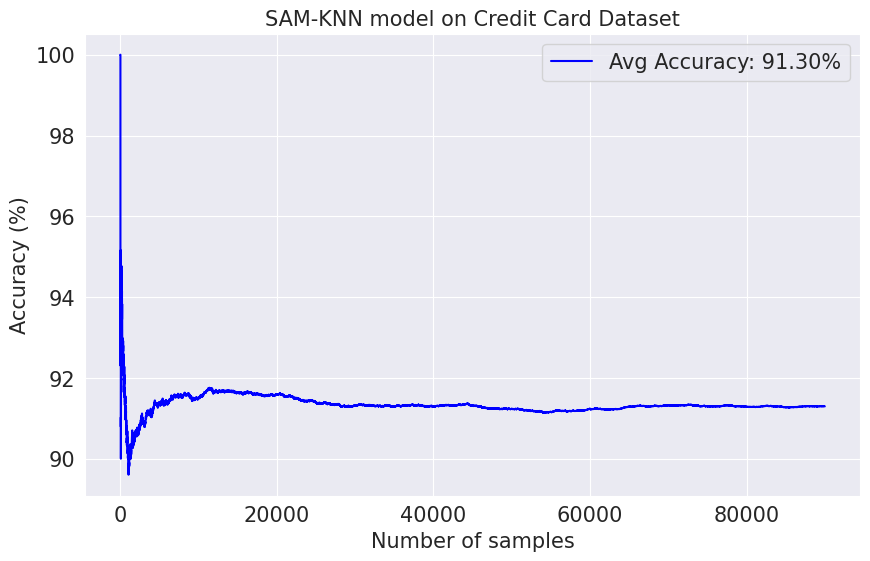

In [87]:
%%time
# Use the Self Adapting Memory (SAM) KNN model 
name6 = "SAM-KNN model"
model6 = neighbors.SAMKNNClassifier(window_size=100) # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 302
Change detected at index 713
Change detected at index 953
Change detected at index 1955
Change detected at index 2824
Change detected at index 3170
Change detected at index 3678
Change detected at index 4131
Change detected at index 4646
Change detected at index 5533
Change detected at index 5984
Change detected at index 6585
Change detected at index 6976
Change detected at index 7430
Change detected at index 7782
Change detected at index 8237
Change detected at index 8659
Change detected at index 8992
Change detected at index 9407
Change detected at index 9791
Change detected at index 10226
Change detected at index 10478
Change detected at index 11023
Change detected at index 11492
Change detected at index 11802
Change detected at index 12071
Change detected at index 12565
Change detected at index 12916
Change detected at index 13213
Change detected at index 13670
Change detected at index 14093
Change detected at index 14531
Change detected at index 15745


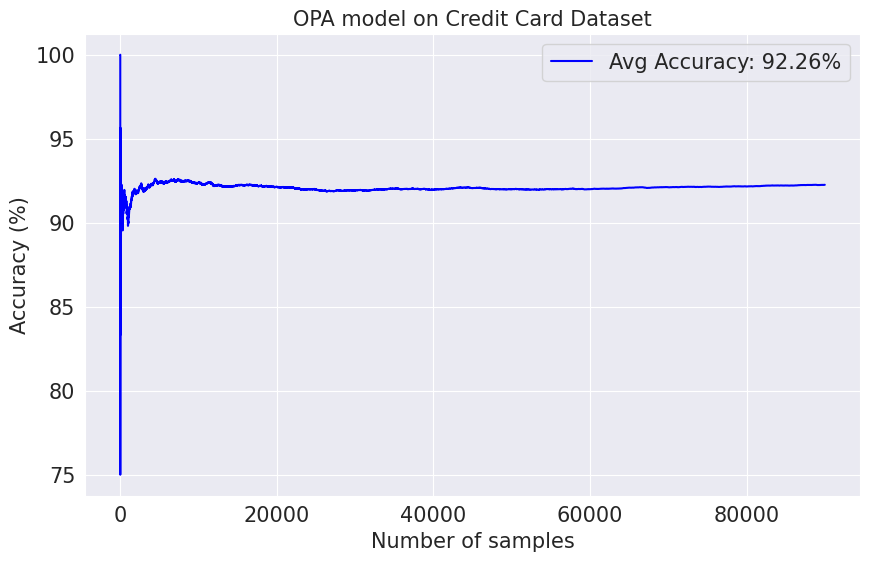

In [89]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name7 = "OPA model"
model7 = linear_model.PAClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 4221
Change detected at index 9321
Change detected at index 16386
Change detected at index 26850
Accuracy: 99.76%
Precision: 98.85000000000001%
Recall: 98.4%
F1-score: 98.63%
CPU times: user 2min 47s, sys: 1.18 s, total: 2min 48s
Wall time: 2min 49s


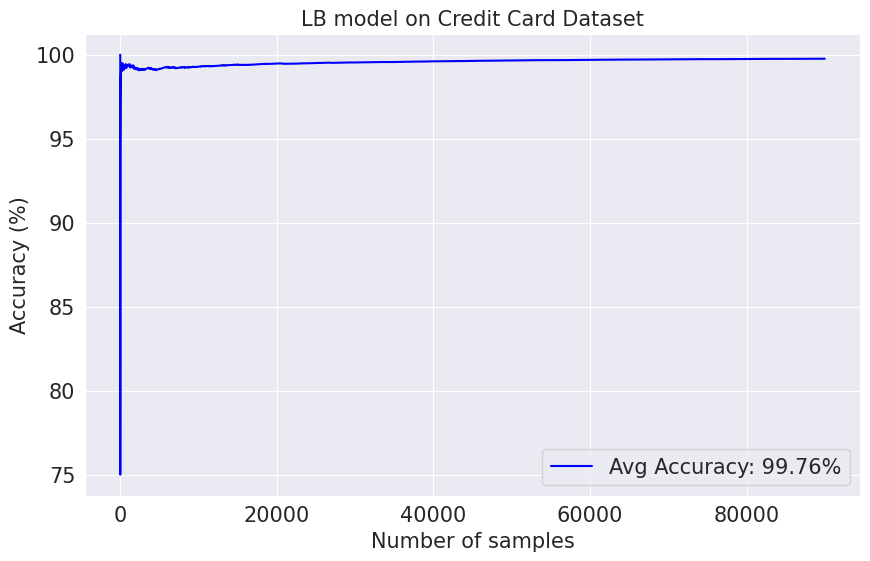

In [93]:
%%time
# Use the Leveraging Bagging (LB) model 
name8 = "LB model"
model8 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # Define the model
t, m8 = adaptive_learning(model8, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [94]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
# proposed in our previous work: https://github.com/Western-OC2-Lab/PWPAE-Concept-Drift-Detection-and-Adaptation
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=2) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=2,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

     #hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN Model
     #hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM Model
     #hat4 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # LB Model

    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=15)
    # Initial FS
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 98.16%
Precision: 89.99000000000001%
Recall: 88.63%
F1-score: 89.3%
CPU times: user 7min 55s, sys: 11.1 s, total: 8min 6s
Wall time: 8min 3s


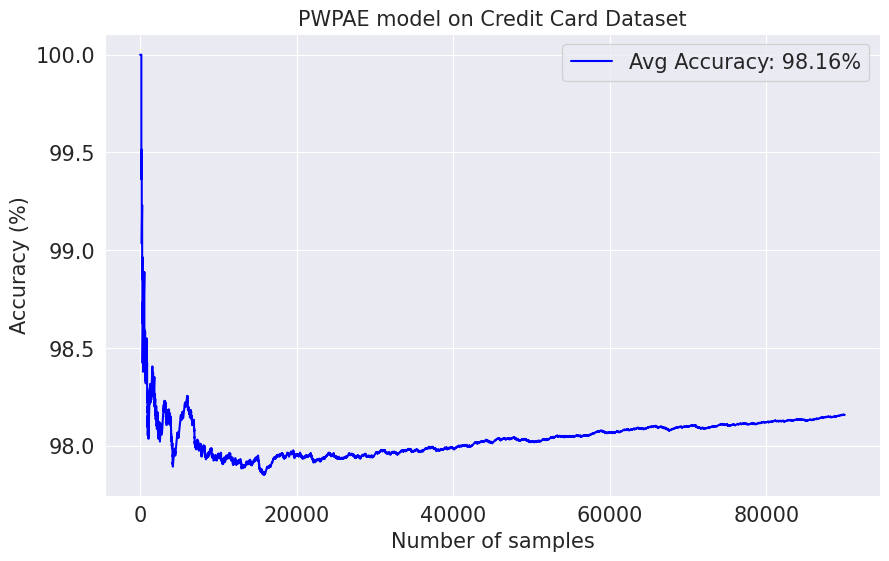

In [96]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model 
name9 = "PWPAE model"
t, m9 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

# 4. Proposed Multi-Stage Automated Network Analytics (MSANA) Framework
Main Module 1: Drift-based Dynamic Feature Selection  
Main Module 2: Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)

In [97]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()
    
    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4
    
    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
    
    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1) 
    
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1) 
        
    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi) 
        y_prob1= hat1.predict_proba_one(xi) 
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi) 
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi) 
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi) 
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)
        
        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)
        
        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)    

        
        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:        
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])

        
        ep = 0.001 # The epsilon used to avoid dividing by 0
        
        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]        

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41
        
#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1
        
        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)
        
        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1 
        in_drift, in_warning = eddm.update(float(val))
        
        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs
        
        # If a drift is detected
        if drift == 1: 
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]
            
            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            #hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat2 = ensemble.SRPClassifier(n_models = 3)
            #hat2 = tree.ExtremelyFastDecisionTreeClassifier()
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # LB Model

            #hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            #hat2 = neighbors.KNNADWINClassifier(window_size=100)
            #hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            #hat4 = linear_model.PAClassifier() # SRP-DDM



          
            
            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)
            
            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)      
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)
                
                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0   
        
        j=1
        

        t.append(i)
        m.append(metric.get()*100)
        
        yt.append(yi)
        yp.append(y_pred)
        
        i=i+1
    
    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Change detected at index 2303
5
Change detected at index 2952
6
Change detected at index 3793
5
Accuracy: 98.6%
Precision: 90.03%
Recall: 94.28999999999999%
F1-score: 92.11%
98.04666666666667
92.70111111111112
98.06222222222222
98.50555555555556
CPU times: user 10min 14s, sys: 11.2 s, total: 10min 25s
Wall time: 10min 23s


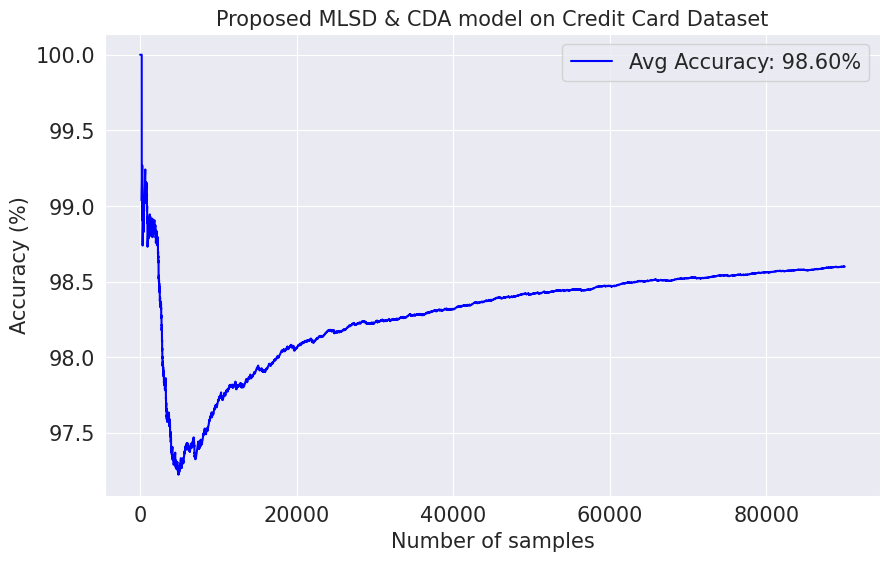

In [108]:
%%time
# Use the proposed Multi-Stage Automated Network Analytics (MSANA) model 

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = ensemble.SRPClassifier(n_models = 3)
#bm2 = tree.ExtremelyFastDecisionTreeClassifier()
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3) # LB Model




name = "Proposed MLSD & CDA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

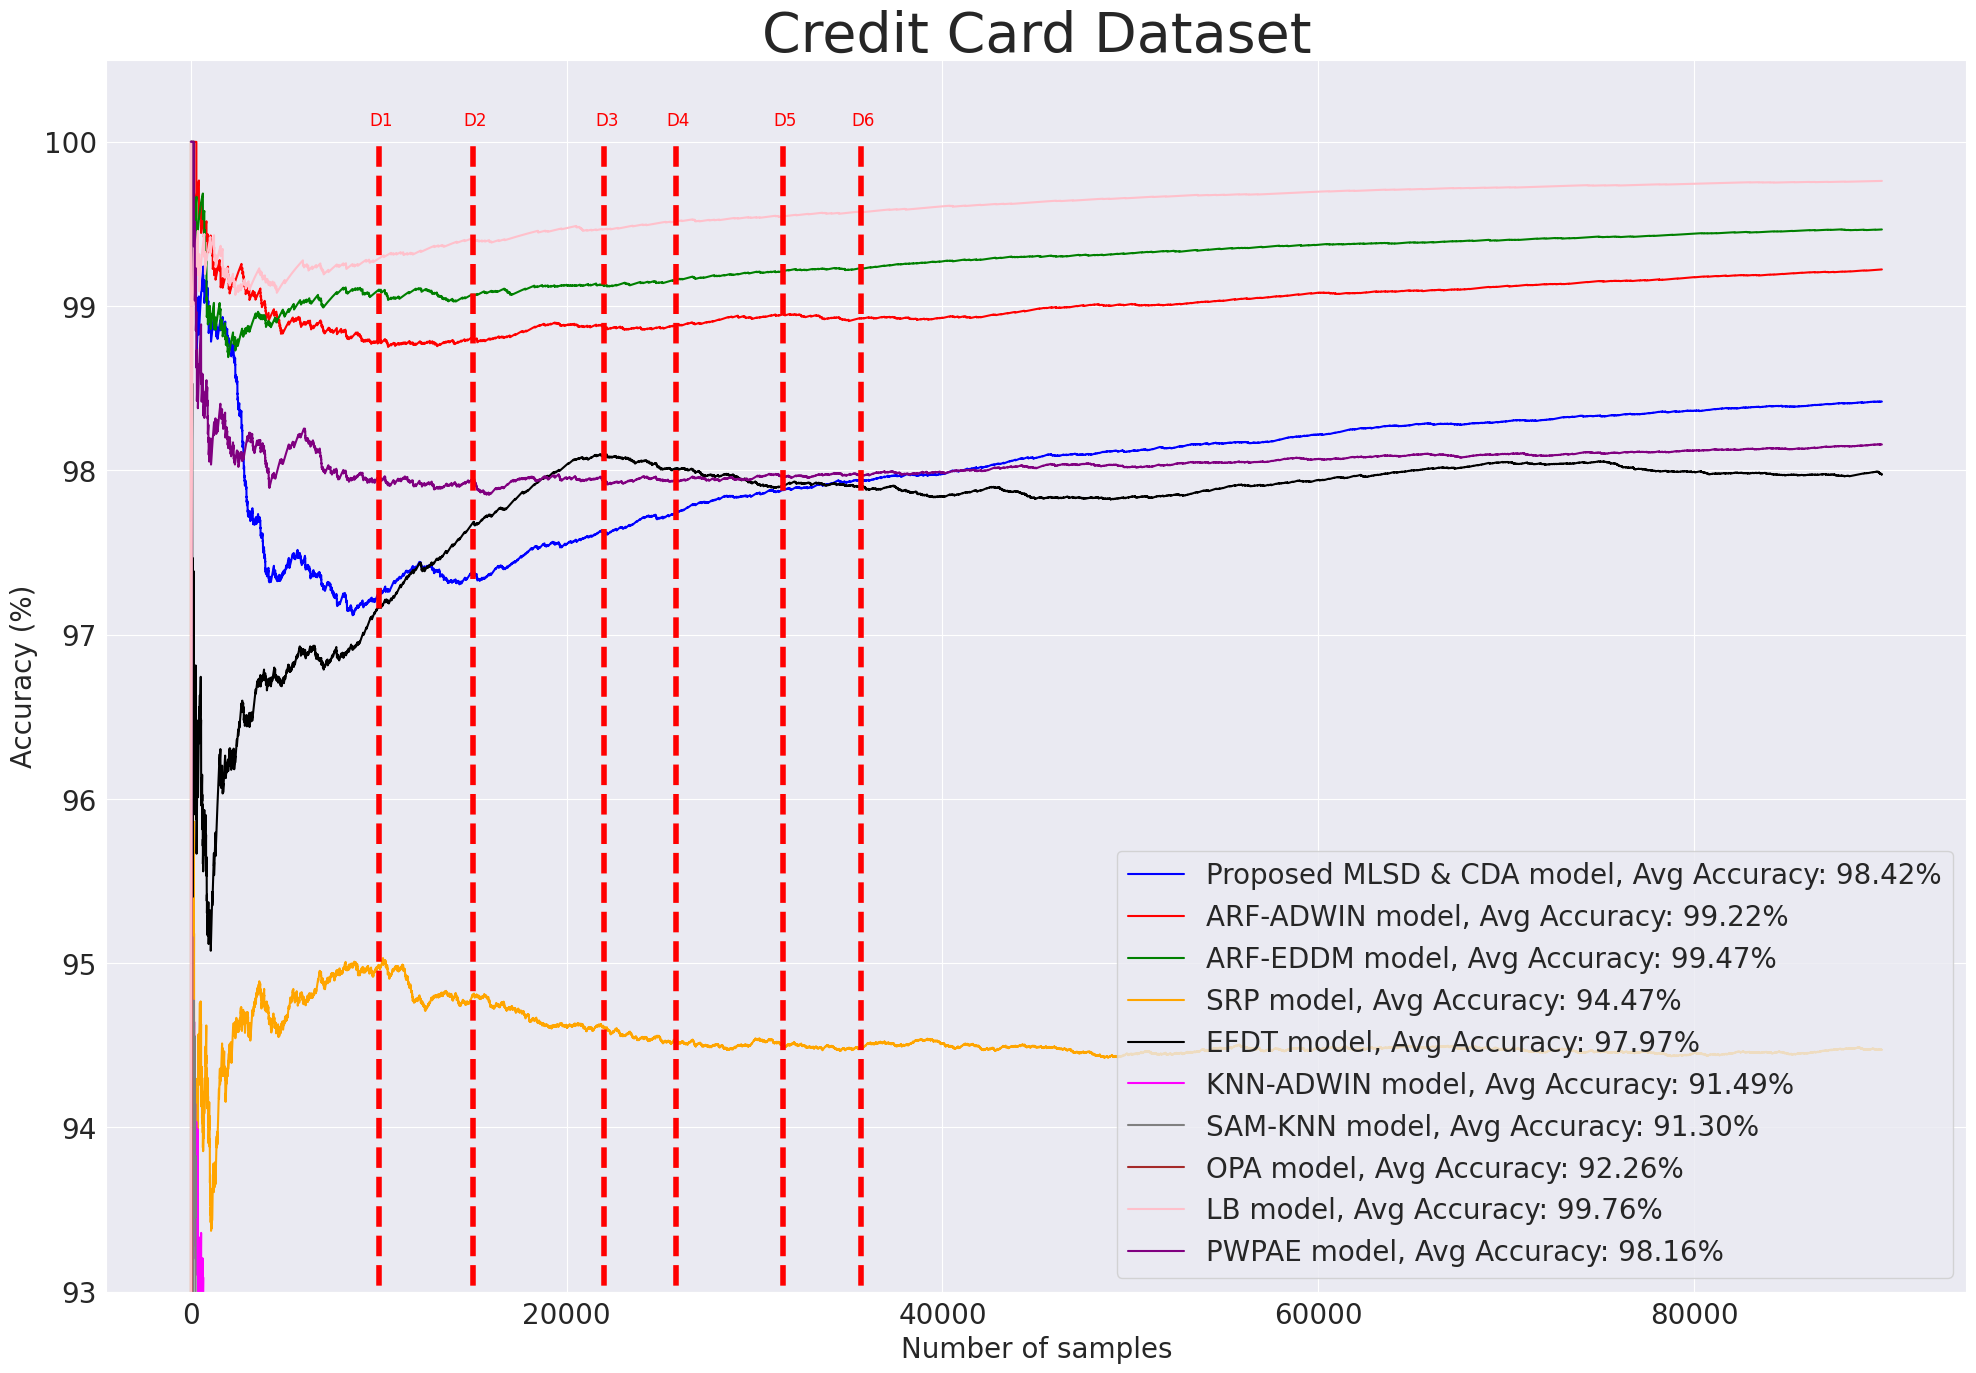

In [101]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 20})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,10000,15000, 22000,25800,31500,35650]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'D'+ str(i), c = "red", fontsize = 12)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('Credit Card Dataset', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()

The performance of the proposed MSANA model outperforms other models. Please note that the results might be different when using different datasets or different subsets of the CICIDS2017 dataset.

Change detected at index 2352
5
Accuracy: 98.61999999999999%
Precision: 89.84%
Recall: 94.76%
F1-score: 92.23%
98.12222222222222
92.70222222222222
98.01444444444445
98.49444444444444
CPU times: user 11min 31s, sys: 12.6 s, total: 11min 44s
Wall time: 11min 42s


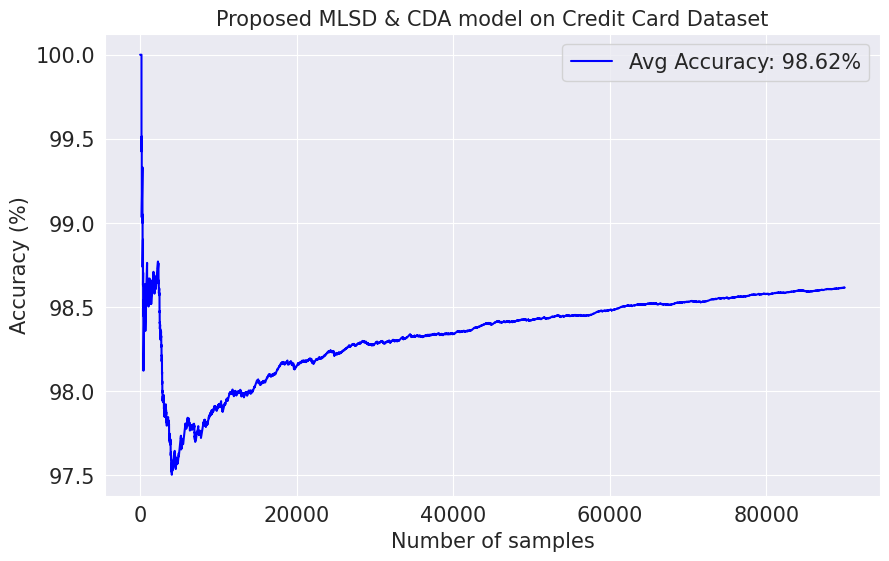

In [111]:
%%time
# Example: combine the ensemble model with dynamic data balancing methods.

bm1 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm2 = imblearn.RandomOverSampler(ensemble.SRPClassifier(n_models = 3),
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm3 = imblearn.RandomOverSampler(ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()), # ARF-EDDM,
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN
bm4 = imblearn.RandomOverSampler(ensemble.LeveragingBaggingClassifier(model=tree.HoeffdingTreeClassifier(),n_models=3), # SRP-DDM
                                 desired_dist={0: .4, 1: .6},
                                seed=42
                                ) # ARF-ADWIN

name = "Proposed MLSD & CDA model"
t, m = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

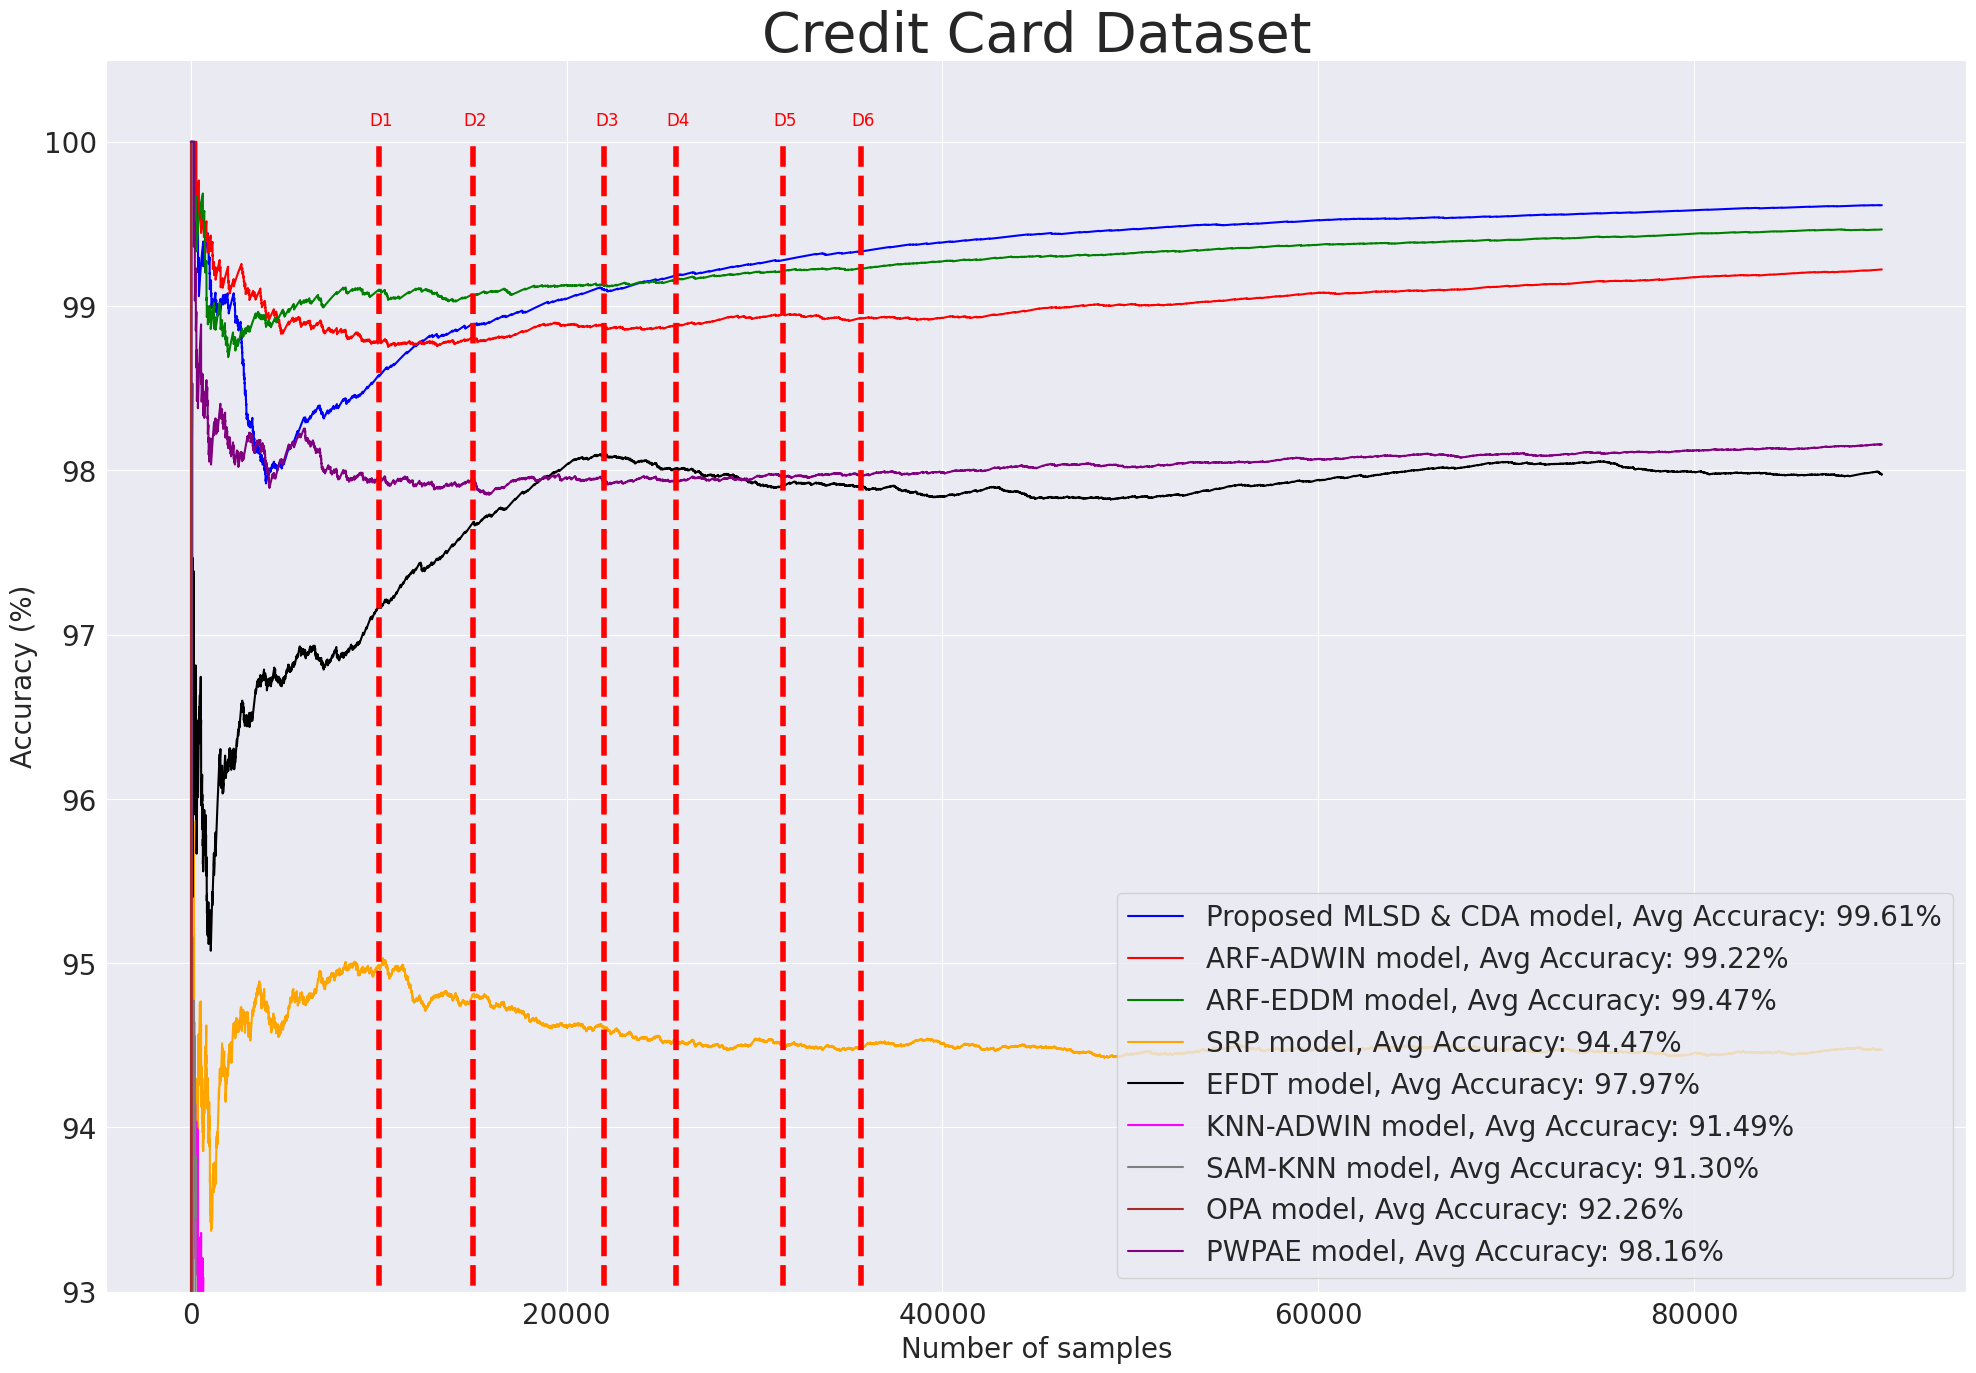

In [106]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 20})
plt.figure(1,figsize=(24,16)) 
sns.set_style("darkgrid")
plt.clf() 

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name+', Avg Accuracy: %.2f%%'%(m[-1]))
# plt.plot(t,m0,'pink',label=name0+', Avg Accuracy: %.2f%%'%(m0[-1]))
plt.plot(t,m1,'-r',label=name1+', Avg Accuracy: %.2f%%'%(m1[-1]))
plt.plot(t,m2,'-g',label=name2+', Avg Accuracy: %.2f%%'%(m2[-1]))
plt.plot(t,m3,'orange',label=name3+', Avg Accuracy: %.2f%%'%(m3[-1]))
plt.plot(t,m4,'black',label=name4+', Avg Accuracy: %.2f%%'%(m4[-1]))
plt.plot(t,m5,'magenta',label=name5+', Avg Accuracy: %.2f%%'%(m5[-1]))
plt.plot(t,m6,'grey',label=name6+', Avg Accuracy: %.2f%%'%(m6[-1]))
plt.plot(t,m7,'brown',label=name7+', Avg Accuracy: %.2f%%'%(m7[-1]))
#plt.plot(t,m8,'pink',label=name8+', Avg Accuracy: %.2f%%'%(m8[-1]))
plt.plot(t,m9,'purple',label=name9+', Avg Accuracy: %.2f%%'%(m9[-1]))

# Draw the drift points/time
dr = [0,10000,15000, 22000,25800,31500,35650]
for i in range(len(dr)):
    if i!=0:
        plt.text(dr[i]-500, 100.1, 'D'+str(i), c = "red", fontsize = 12)
        plt.vlines(dr[i], 0, 100, colors = "red", linewidth=4, linestyles = "dashed")
        
plt.legend(loc='lower right')
plt.ylim(93, 100.5)
plt.title('Credit Card Dataset', fontsize=40)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.draw()